# Fruit Image Classification

This is a notebook for the data set https://www.kaggle.com/datasets/chrisfilo/fruit-recognition

This is an image classification problem. We have images of 15 different classes of fruits. We want to build a CNN to detect which kind of fruit is shown in the image.

First we download the data from the kaggle repository, this is done manually. 

Then we load some libraries to our notebook and declare some variables to be used later

In [1]:
import os
import imutils
import numpy as np
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
import skimage as sk
from skimage import transform
import copy
from PIL import Image
import skimage.exposure as exposure
import random
import gc

import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# path of directory with images
main_path = '/home/gabriel/Desktop/Freelancer/Sandro/data/'

## Data exploring

We start exploring our data. We care about how many directories do we have, the images in each directory. Detect possible duplicated data.    

In [2]:
'''
auxiliar function to explore directories
'''
def explore_directory(in_path):
    n_img = 0
    n_dir = 0
    print("Exploring directory '"+in_path+"':")
    print("inside directories: ")
    for f in os.listdir(in_path):
        if 'csv' in f:
            continue
        print("\n    -> "+f)
        if "png" in os.listdir(in_path+f)[0]:            
            print("         with "+str(len(os.listdir(in_path+f)))+" images")
            n_img += len(os.listdir(in_path+f))
            n_dir += 1
        else:
            print("       inside directories:")
            n_s_img = 0
            for d in os.listdir(in_path+f):
                if 'csv' in d:
                    continue
                print("           -> "+d)
                print("                with "+str(len(os.listdir(in_path+f+"/"+d)))+" images")
                n_img += len(os.listdir(in_path+f+"/"+d))
                n_s_img += len(os.listdir(in_path+f+"/"+d))
                n_dir += 1
            print("         with "+str(n_s_img)+" images")    
    print("\n TOTAL IMAGES: "+str(n_img))
    print(" TOTAL DIR WITH IMAGES: "+str(n_dir))

In [3]:
explore_directory(main_path)

Exploring directory '/home/gabriel/Desktop/Freelancer/Sandro/data/':
inside directories: 

    -> Pitaya
         with 2502 images

    -> Banana
         with 3028 images

    -> Guava
       inside directories:
           -> guava A
                with 1512 images
           -> guava B
                with 1626 images
           -> Guava total
                with 12552 images
           -> guava total final
                with 4008 images
         with 19698 images

    -> Peach
         with 2630 images

    -> Apple
       inside directories:
           -> Apple D
                with 1033 images
           -> Apple B
                with 740 images
           -> Apple F
                with 2030 images
           -> Apple E
                with 664 images
           -> Total Number of Apples
                with 5024 images
           -> Apple C
                with 1002 images
           -> Apple A
                with 692 images
         with 11185 images

    -> Mango
      

#### Observations:

1) We see that each fruit directory can have i) images or be divided into other ii) subdirectories that  have images.

2) The number of images for each fruit is very different, from 2072 for "Persimmon" to 19698 for "Guava".

3) The directories with subdirectories have the names "Total Number of $fruit" (or variants). Which means that probably there are duplicated data. 


At the moment of loading the data for our model we will have to use a similar amount of images for each fruit. Otherwise we can have a biased classificator.

We will plot some images to see what kind of data do we have 

In [4]:
'''
auxiliar function to plot images from a directory 
'''
def show_directory_with_imgs(in_path, read_func, gray=False):
    n_img = 0
    fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
    
    cont = 0
    
    def get_axes_index(cont):
        a = cont//6
        b = cont - a*6
        return a,b
    
    for f in os.listdir(in_path):
        if 'csv' in f:
            continue
        if "png" in os.listdir(in_path+f)[0]:
            a, b = get_axes_index(cont)
            if gray:
                axes[b][a].imshow(read_func(in_path+f+"/"+os.listdir(in_path+f)[0]), cmap='gray')
            else:    
                axes[b][a].imshow(read_func(in_path+f+"/"+os.listdir(in_path+f)[0]))
            
            axes[b][a].set_title(f, fontsize = 18, color='g')
            cont += 1
        else:
            for d in os.listdir(in_path+f):
                if 'csv' in d:
                    continue
                a, b = get_axes_index(cont)
                if gray:
                    axes[b][a].imshow(read_func(in_path+f+"/"+d+"/"+os.listdir(in_path+f+"/"+d)[0]), cmap='gray')
                else:
                    axes[b][a].imshow(read_func(in_path+f+"/"+d+"/"+os.listdir(in_path+f+"/"+d)[0]))
                
                axes[b][a].set_title(d, fontsize = 18, color='g')
                cont += 1
    plt.tight_layout(pad=0.0)
    plt.show() 
    return 

'''
Here we read the image from "image path"
resize it to "sze" X "sze" 
apply a fast denoising function from opencv
'''
def process_img_color(image_path, sze=None ):
    #parameters for denoising
    h=10
    templateWindowSize=7
    searchWindowSize=21
    hColor=10

    #read+resize+denoising
    img = cv2.imread( image_path )
  
    img = cv2.cvtColor( img, cv2.COLOR_BGR2RGB)
    if sze!=None:
        img = cv2.resize( img, (sze,sze) )
    img = cv2.fastNlMeansDenoisingColored(img,None,h,hColor,templateWindowSize,searchWindowSize)
    return img

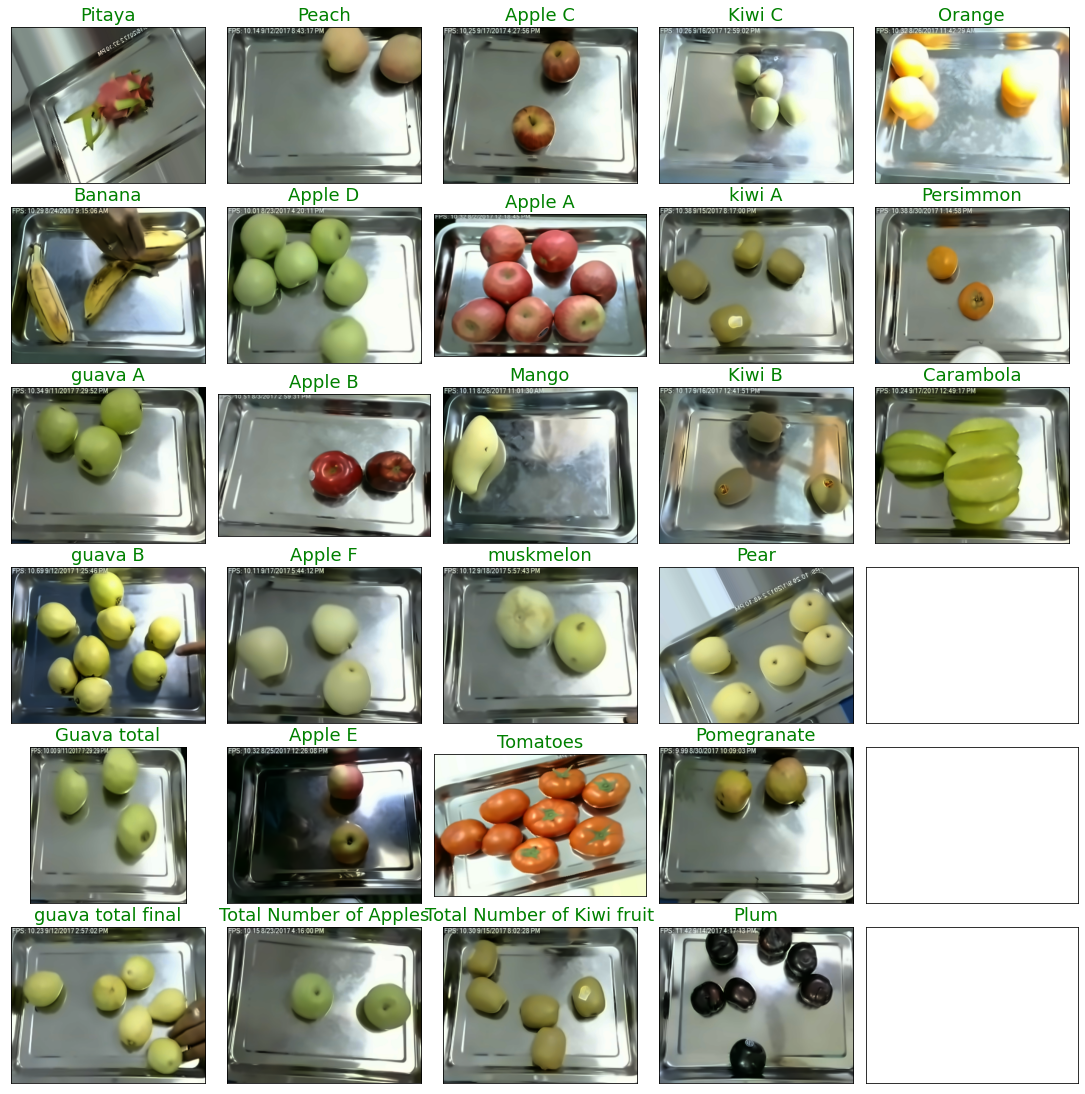

In [5]:
show_directory_with_imgs(main_path, process_img_color)

We see that the fruits that have subdirectories are probably divided by species, that change in color, or size. We also see that some photos are very bright (Orange image), or are rotated (Pitaya image). 

We will see what happens after some preprocessing and extracting features. We will apply some classical denoising algorithms from OpenCV, and extract features will help us to see the shape of the fruit, rather than its color.

In [6]:
'''
Here we read the image from "image path"
convert to gray scale (to later on extract features)
resize it to "sze" X "sze" 
apply a fast denoising function from opencv
'''
def process_img(image_path, sze=None):
    #parameters for denoising
    h=10
    templateWindowSize=7
    searchWindowSize=21

    #read+gray+resize+denoising
    img = cv2.imread( image_path )
  
    img = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY)
    if sze!=None:
        img = cv2.resize( img, (sze,sze) )
    img = cv2.fastNlMeansDenoising(img,None,h,templateWindowSize,searchWindowSize)
    return img

'''
Here we take the output from process_img
and extract the following features (using cv)
1 Sobel Edge
'''
def feature_extraction(img):

    #parameters for Gaussian blur
    GBlur = 0
    SBlur = 1.3
    
    #parameters for Sobel Edge detection
    ksize_s = 3
    
    
    #Gaussian Blur
    img_blur = cv2.GaussianBlur(img, (GBlur,GBlur), sigmaX=SBlur, sigmaY=SBlur )
    
    #Sobel Edge
    sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=ksize_s) # Sobel Edge Detection on the X axis
    sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=ksize_s) # Sobel Edge Detection on the Y axis
    sobelx2 = cv2.multiply(sobelx,sobelx)
    sobely2 = cv2.multiply(sobely,sobely)
    # add together and take square root
    sobel_magnitude = cv2.sqrt(sobelx2 + sobely2)
    # normalize to range 0 to 255 and clip negatives
    sobel_magnitude = exposure.rescale_intensity(sobel_magnitude, in_range='image', out_range=(0,255)).clip(0,255).astype(np.uint8)
        
    
    return  sobel_magnitude

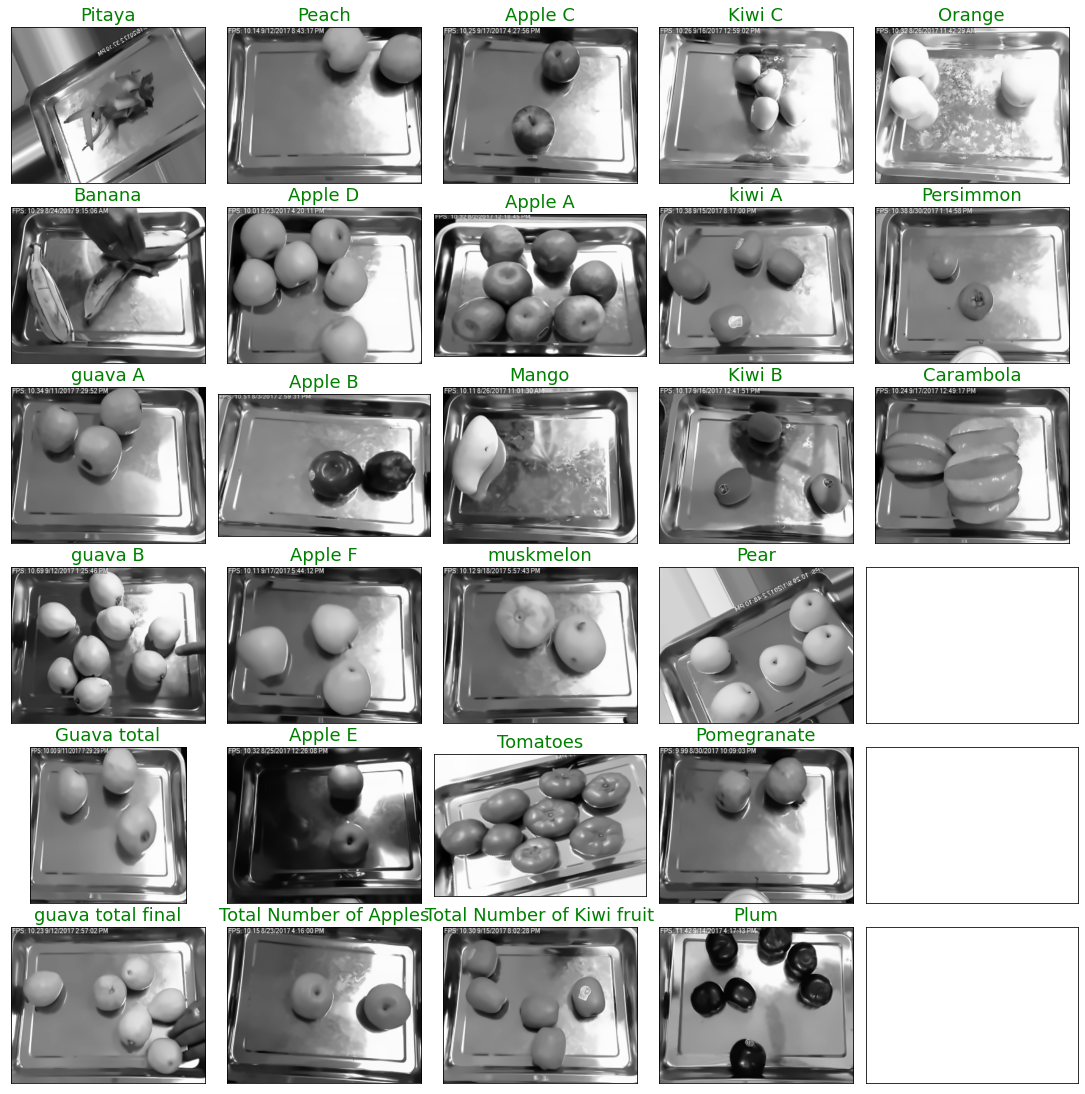

In [7]:
# Gray scale image
show_directory_with_imgs(main_path, lambda x: process_img(x), True)

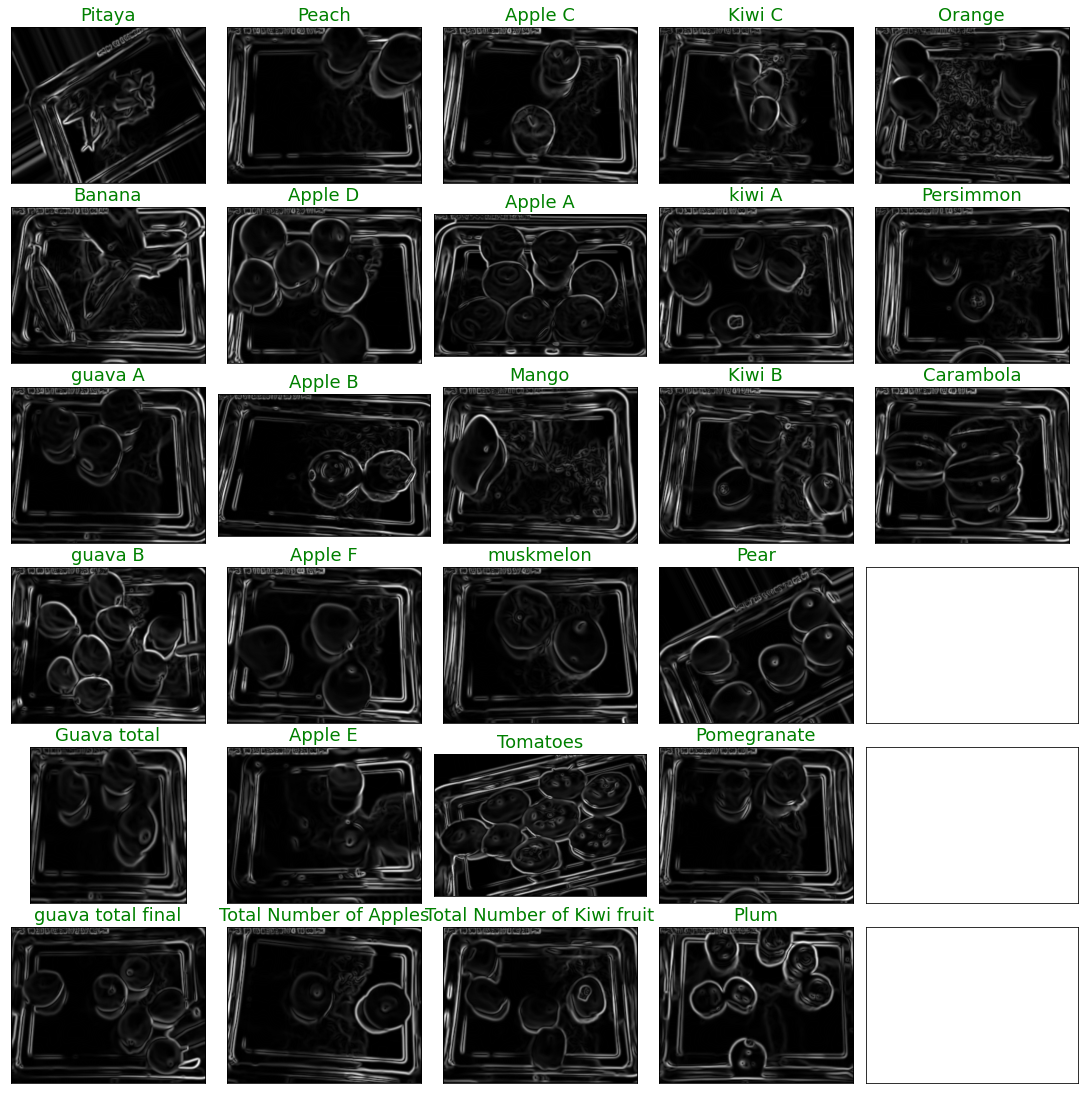

In [8]:
# Sobel Edge detection image
show_directory_with_imgs(main_path, lambda x: feature_extraction(process_img(x)), True)

We can see that using a gray scale image and a Sobel Edge feature we might overcome color and brightness issues. Given that observation we decide to train 3 ANN models with different architectures: one ANN model with only the fully colored image, and two ANN variants with the three images (fully colored + gray scale + Sobel edge). With this we will test if the extra features help in the image classification, and if the way that we mix the information of the features also affects the classification.

## Collecting DATA + Preprocessing + Feature extraction

Since reading each image for each experiment takes time, specially in google colab, we will do the following:
1. Collect the data
2. Resize the images
3. Denoise
4. Extract features
5. Create a dataframe with the cleaned data

In [9]:
'''
Here we read the image from "image path"
convert to gray scale (to later on extract features)
resize it to "sze" X "sze" 
apply a fast denoising function from opencv
extract Sobel Edge feature
return dic with image
'''
def process_img_full(image_path, sze=None):
    #parameters for denoising
    h=10
    templateWindowSize=7
    searchWindowSize=21
    hColor=10
    
    #read+gray+resize+denoising
    img = cv2.imread( image_path )  
    if sze!=None:
        img = cv2.resize( img, (sze,sze) )
    
    img_g = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY)    
    img_g = cv2.fastNlMeansDenoising(img_g,None,h,templateWindowSize,searchWindowSize)
    img = cv2.fastNlMeansDenoisingColored(img,None,h,hColor,templateWindowSize,searchWindowSize)
    img_sobel = feature_extraction(img_g)
    
    return {'SobelEdgeXY':img_sobel, 'GrayImage':img_g, 'Blue':img[:,:,0], 'Green':img[:,:,1], 'Red':img[:,:,0]}
    
'''
function to load images from a folder
and apply process_img function to them
'''
def load_images_from_folder(folder, sample_size, sze=None, label=""):
    files=[ f for f in os.listdir(folder) if "png" in f]    
    images = []
    for filename in random.sample(files,sample_size):
        image_path = os.path.join(folder, filename)
        if "png" in image_path:
            images.append( (process_img_full(image_path, sze), label) )
    return images    

'''
function to create the dataframe with the images + features + label
it recives a directory "in_path", reads the images in there,
extrats the features of each image, and then creates a DataFrame
with the list of images.
It also saves the DataFrame in "out_path" in compressed form 
'''
def create_dataframe( in_path, out_path, sample_size, subfolder_list, sze=None):
    compression_opts = dict(method='zip',
                        archive_name='fruit_features.csv')
    
    for f in os.listdir(in_path):    
        print("Loading "+in_path+f)
        df = {'Fruit':[], 'GrayImage':[], 'SobelEdgeXY':[], 'Blue':[], 'Green':[], 'Red':[]}
        images = []
        if "png" in os.listdir(in_path+f)[0]:
            images = load_images_from_folder(in_path+f, sample_size, sze, label=f)
        else: 
            for d in os.listdir(in_path+f):
                if d in subfolder_list:
                    images = load_images_from_folder(in_path+f+"/"+d, sample_size, sze, label=f)
        df = _create_dataframe(images, df)
        
        df = pd.DataFrame(df).sample(frac=1)
        df.to_csv(in_path+f+'/'+'000_images.csv.zip', compression=compression_opts, index=False)
        
  
    df_S = pd.concat([pd.read_csv( in_path+f+'/000_images.csv.zip' ).sample(frac=0.1) for f in os.listdir(in_path)])
    df_S.to_csv(out_path+'000_images_sample.csv.zip', compression=compression_opts, index=False)
    df_S = None
    
    df = pd.concat([pd.read_csv( in_path+f+'/000_images.csv.zip' ) for f in os.listdir(in_path)])                 
    df.to_csv(out_path+'000_images.csv.zip', compression=compression_opts, index=False)
    return df

'''
auxiliar function to create_dataframe
'''
def _create_dataframe(images, df):
    while  len(images)>0:
        data = images.pop()
        df['Fruit'].append(data[1])
        feature = data[0]        
        for key in feature.keys():
            df[key].append( _img_to_str(feature[key]) )
    return df

'''
auxiliar function to code an image array into a string
'''
def _img_to_str(img):
    return str(img.flatten().tolist()).replace(']','').replace('[','')

'''
auxiliar function to code a string into a gray image array
'''
def _str_to_arr_g(st, sze):
    return np.array(st.split(', ')).astype(np.float32).reshape( (sze,sze) )/255

'''
auxiliar function to code a string into a color image array
'''
def _str_to_arr_c(st_b, st_g, st_r, sze):
    img_r = np.array(st_r.split(', ')).astype(np.float32).reshape( (sze,sze) )/255
    img_g = np.array(st_g.split(', ')).astype(np.float32).reshape( (sze,sze) )/255
    img_b = np.array(st_b.split(', ')).astype(np.float32).reshape( (sze,sze) )/255
    return np.array([img_r, img_g, img_b]).transpose()

In [10]:
# image size is sze X sze 
sze = 150

# to do tests we will use sample data, to do the real run we will use all data
use_sample_data=True

# sample size
sample_size = 2000  #approx min number of one class of fruit

# subfolders to extract images from
subfolder_list = ["Total Number of Kiwi fruit", "Total Number of Apples", "Guava total"]
 
if use_sample_data:
    if os.path.exists(main_path+'/000_images_sample.csv.zip'):
        print("load Sample DataFrame csv file")
        df = pd.read_csv( main_path+'/000_images_sample.csv.zip' )
    else:
        print("create Sample DataFrame csv file")
        df = create_dataframe( main_path, main_path, sample_size, subfolder_list, sze)
        df = pd.read_csv( main_path+'/000_images_sample.csv.zip' )
else:
    if os.path.exists(main_path+'/000_images.csv.zip'):
        print("load DataFrame csv file")
        df = pd.read_csv( main_path+'/000_images.csv.zip' )
    else:
        print("create DataFrame csv file")
        df = create_dataframe( main_path, main_path, sample_size, subfolder_list, sze)
        
# Assign to each fruit a specific number
fruit_names = sorted(df["Fruit"].unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["Label"] = df["Fruit"].map(mapper_fruit_names)
n_fruit = len(mapper_fruit_names)


load Sample DataFrame csv file


## The ANN models
We create three models with different architecture to solve the classification problem 

In [11]:
'''
writes a full keras model for our data, 
inputs: color image
outputs: one hot encoding of fruit categorical variable
'''    
def get_model_0(size, out, partial_out, activation='relu', n_times=5):
    # shapes
    shape_color=(size,size,3)
    
    inputs = keras.Input(shape=shape_color, name='color_input')
    
    x = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding = 'same' )(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    
    for ii in range(n_times):
        x = Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding = 'same' )(x)
        x = MaxPooling2D(pool_size=2)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation=activation)(x)
    x = Dropout(0.5)(x)  

    x = Dense(partial_out, activation=activation)(x)
    x = Dropout(0.1)(x)
    outputs = Dense(out, activation='softmax', name='output')(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [12]:
'''
writes a keras partial CNN model 
'''
def get_partial_model_1(shape_img, out, name, activation='relu', n_times=5):
    inputs = keras.Input(shape=shape_img)
    
    x = Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation=activation, padding = 'same' )(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    
    for ii in range(n_times):
        x = Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding = 'same' )(x)
        x = MaxPooling2D(pool_size=2)(x)
    
    #x = Flatten()(x)
    #x = Dense(256, activation=activation)(x)
    outputs = Dropout(0.5)(x)
    #outputs = Dense(out, activation=activation)(x)
    return keras.Model(inputs, outputs, name=name)

'''
auxiliar function to conver number of layers
'''
def get_number_layers(k):
    if(k%2)==0:
        return k//2, k//2
    else:
        return k//2+1, k//2
    
'''
writes a full keras model for our data, 
inputs: gray image, sobel image, color image
outputs: one hot encoding of fruit categorical variable
'''    
def get_model_1(size, out, partial_out, activation='relu', n_times=5):
    # shapes    
    shape_gray=(size,size,1)
    shape_color=(size,size,3)
    
    # number of convolutional layers
    n_0, n_1 = get_number_layers(n_times)
    
    # inputs
    gray_input  = keras.Input(shape=shape_gray,  name='gray_input')
    sobel_input = keras.Input(shape=shape_gray,  name='sobel_input')
    color_input = keras.Input(shape=shape_color, name='color_input')

    # partial models
    gray_model  = get_partial_model_1(shape_gray,  partial_out, 'gray_model' , 'relu', n_0)
    sobel_model = get_partial_model_1(shape_gray,  partial_out, 'sobel_model', 'relu', n_0)
    color_model = get_partial_model_1(shape_color, partial_out, 'color_model', 'relu', n_0)
    
    y1 = gray_model(gray_input)
    y2 = sobel_model(sobel_input)
    y3 = color_model(color_input)
    
    x = add([y1, y2, y3], name='add_models')
    
    for ii in range(n_1):
        x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same' )(x)
        x = MaxPooling2D(pool_size=2)(x)
    
    x = Flatten()(x)
    x = Dense(partial_out, activation=activation)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(out, activation='softmax', name='output')(x)

    return keras.Model(inputs=[gray_input, sobel_input, color_input], outputs=outputs)    

In [13]:
'''
writes a keras partial CNN model 
'''
def get_partial_model_2(shape_img, out, name, activation='relu', n_times=5):
    inputs = keras.Input(shape=shape_img)
    
    x = Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation=activation, padding = 'same' )(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    
    for ii in range(n_times):
        x = Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding = 'same' )(x)
        x = MaxPooling2D(pool_size=2)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation=activation)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(out, activation=activation)(x)
    return keras.Model(inputs, outputs, name=name)
    
'''
writes a full keras model for our data, 
inputs: gray image, sobel image, color image
outputs: one hot encoding of fruit categorical variable
'''    
def get_model_2(size, out, partial_out, activation='relu', n_times=5):
    # shapes    
    shape_gray=(size,size,1)
    shape_color=(size,size,3)
    
    # number of convolutional layers
    n_0, n_1 = n_times, 0
    
    # inputs
    gray_input  = keras.Input(shape=shape_gray,  name='gray_input')
    sobel_input = keras.Input(shape=shape_gray,  name='sobel_input')
    color_input = keras.Input(shape=shape_color, name='color_input')

    # partial models
    gray_model  = get_partial_model_2(shape_gray,  partial_out, 'gray_model' , 'relu', n_0)
    sobel_model = get_partial_model_2(shape_gray,  partial_out, 'sobel_model', 'relu', n_0)
    color_model = get_partial_model_2(shape_color, partial_out, 'color_model', 'relu', n_0)
    
    y1 = gray_model(gray_input)
    y2 = sobel_model(sobel_input)
    y3 = color_model(color_input)
    
    x = concatenate([y1, y2, y3], name='concatenate_models')

    x = Dense(3*partial_out, activation=activation)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(out, activation='softmax', name='output')(x)

    return keras.Model(inputs=[gray_input, sobel_input, color_input], outputs=outputs)  

In [14]:
#model = get_model(image_size, number_categories, output_dense_layer,
#                  activation_function_dense_layer, number_convolutional_layers)  
model_0 = get_model_0(sze, n_fruit, 45,  'relu', 5)
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 color_input (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        36928 

In [15]:
#model = get_model(image_size, number_categories, output_dense_layer,
#                  activation_function_dense_layer, number_convolutional_layers)                  
model_1 = get_model_1(sze, n_fruit, 256,  'relu', 5)
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gray_input (InputLayer)        [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sobel_input (InputLayer)       [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 color_input (InputLayer)       [(None, 150, 150, 3  0           []                               
                                )]                                                          

In [16]:
#model = get_model(image_size, number_categories, output_dense_layer,
#                  activation_function_dense_layer, number_convolutional_layers)  
model_2 = get_model_2(sze, n_fruit, 15,  'relu', 5)
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gray_input (InputLayer)        [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sobel_input (InputLayer)       [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 color_input (InputLayer)       [(None, 150, 150, 3  0           []                               
                                )]                                                          

## Training and Testing the models

We divide the data set in Test, Train and Validation subsets. Then we train each model with the train subset, we use the validation subset to measure our training, and finally, one that the model have been trained, we use the test subset to determinate which model performed better.

In [17]:
'''
auxiliar function to convert a one hot encoding to an integer number 
'''
def from_categorical(lst): 
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2


'''
function to display several metrics comparing
the predicted output against the real output
of the test subset
'''
def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    pred = from_categorical(pred)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    accur = accuracy_score(y_test_class, pred)
    print(f"# Accuracy: {round(accur,5)}")
    return accur


'''
function to plot the history of the trained model
'''    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()
    return


'''
auxiliar function to convert a model.history into a DataFrame
'''
def get_single_DataFrame(model, name):
    history = pd.DataFrame(model.history.history)
    return history.rename(columns={"accuracy":"accuracy_"+name, "val_accuracy":"val_accuracy_"+name})[["accuracy_"+name, "val_accuracy_"+name]]


'''
function to plot the training history of our three models at the same time
'''
def plot_training_models(model_0, model_1, model_2, name_model_0, name_model_1, name_model_2):
    
    history_0 = get_single_DataFrame(model_0, name_model_0)
    history_1 = get_single_DataFrame(model_1, name_model_1)
    history_2 = get_single_DataFrame(model_2, name_model_2)
    history = history_0.join(history_1,how='outer').join(history_2,how='outer')    
    history.plot(figsize=(15,15))
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()
    return
    

'''
function to train the 3 models and test them 
'''    
def compare_models(model_0, model_1, model_2, inputs_train, outputs_train, inputs_test, outputs_tes, 
                   epochs, batch_size, validation_split, verbose=1, name_model_0='model_0', name_model_1='model_1', name_model_2='model_2'):    

    # Checkpoint 
    # If the ANN doesn't increase its prediction accuracy on the validation data after 
    # 10 epochs, stop the training and take the best of the ANN.
    callbacks_0 = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=name_model_0+'_best.h5', monitor='val_loss', save_best_only=True)]    
    
    callbacks_1 = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=name_model_1+'_best.h5', monitor='val_loss', save_best_only=True)]
    
    callbacks_2 = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=name_model_2+'_best.h5', monitor='val_loss', save_best_only=True)]      

    
    
    print("\n### trainning "+name_model_0+" ###")
    model_0.fit(
        inputs_train["color_input"],
        outputs_train["output"],
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks_0,
        validation_split = validation_split,
        verbose = verbose
    )

    # Run the garbage collector
    gc.collect()
    
    
    print("\n### trainning "+name_model_1+" ###")
    model_1.fit(
        inputs_train,
        outputs_train,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks_1,
        validation_split = validation_split,
        verbose = verbose
    )

    # Run the garbage collector
    gc.collect()
    
    
    print("\n### trainning "+name_model_2+" ###")
    model_2.fit(
        inputs_train,
        outputs_train,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks_2,
        validation_split = validation_split,
        verbose = verbose
    )

    # Run the garbage collector
    gc.collect()
    

    print("\n### RESULTS ###")
    
    
    plot_training_models(model_0, model_1, model_2, name_model_0, name_model_1, name_model_2)
    
    print("\n==================================================")
    print(name_model_0)
    #plot_training(model_0)
    outputs_predicted = model_0.predict(inputs_test["color_input"])
    accur_0 = display_stats(outputs_test["output"], outputs_predicted)
    

    print("\n==================================================")
    print(name_model_1)
    #plot_training(model_1)
    outputs_predicted = model_1.predict(inputs_test)
    accur_1 = display_stats(outputs_test["output"], outputs_predicted)
    
    print("\n==================================================")
    print(name_model_2)
    #plot_training(model_2)
    outputs_predicted = model_2.predict(inputs_test)
    accur_2 = display_stats(outputs_test["output"], outputs_predicted) 
    
    print("\n==================================================")    
    a = [accur_0, accur_1, accur_2]
    b = [name_model_0, name_model_1, name_model_2]
    print("Best accuracy from "+b[np.argmax(a)])


        
    return model_0, model_1, model_2    
    

### some parameters ###
test size  300
train size 2430
val size   270
batch size 128

### decoding data ###

### trainning model_0 ###
Epoch 1/100
19/19 [==============================] - 74s 4s/step - loss: 2.7090 - accuracy: 0.0642 - val_loss: 2.7088 - val_accuracy: 0.0481
Epoch 2/100
19/19 [==============================] - 72s 4s/step - loss: 2.6982 - accuracy: 0.0786 - val_loss: 2.6599 - val_accuracy: 0.1259
Epoch 3/100
19/19 [==============================] - 73s 4s/step - loss: 2.5604 - accuracy: 0.1403 - val_loss: 2.4276 - val_accuracy: 0.1519
Epoch 4/100
19/19 [==============================] - 73s 4s/step - loss: 2.3589 - accuracy: 0.1716 - val_loss: 2.1140 - val_accuracy: 0.2148
Epoch 5/100
19/19 [==============================] - 72s 4s/step - loss: 2.0590 - accuracy: 0.2580 - val_loss: 1.8301 - val_accuracy: 0.2852
Epoch 6/100
19/19 [==============================] - 73s 4s/step - loss: 1.8345 - accuracy: 0.3432 - val_loss: 1.6584 - val_accuracy: 0.3593
Epoch 7/100
19/19 [

/home/gabriel/anaconda3/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


19/19 [==============================] - 214s 11s/step - loss: 2.7118 - accuracy: 0.0609 - val_loss: 2.7087 - val_accuracy: 0.0407
Epoch 2/100
19/19 [==============================] - 206s 11s/step - loss: 2.7021 - accuracy: 0.0774 - val_loss: 2.6840 - val_accuracy: 0.1000
Epoch 3/100
19/19 [==============================] - 238s 13s/step - loss: 2.6101 - accuracy: 0.1362 - val_loss: 2.4896 - val_accuracy: 0.1889
Epoch 4/100
19/19 [==============================] - 205s 11s/step - loss: 2.3351 - accuracy: 0.2440 - val_loss: 2.0912 - val_accuracy: 0.3333
Epoch 5/100
19/19 [==============================] - 205s 11s/step - loss: 1.9843 - accuracy: 0.3449 - val_loss: 1.7373 - val_accuracy: 0.4148
Epoch 6/100
19/19 [==============================] - 205s 11s/step - loss: 1.6421 - accuracy: 0.4432 - val_loss: 1.3745 - val_accuracy: 0.5296
Epoch 7/100
19/19 [==============================] - 206s 11s/step - loss: 1.3982 - accuracy: 0.5292 - val_loss: 1.1364 - val_accuracy: 0.6222
Epoch 8/100

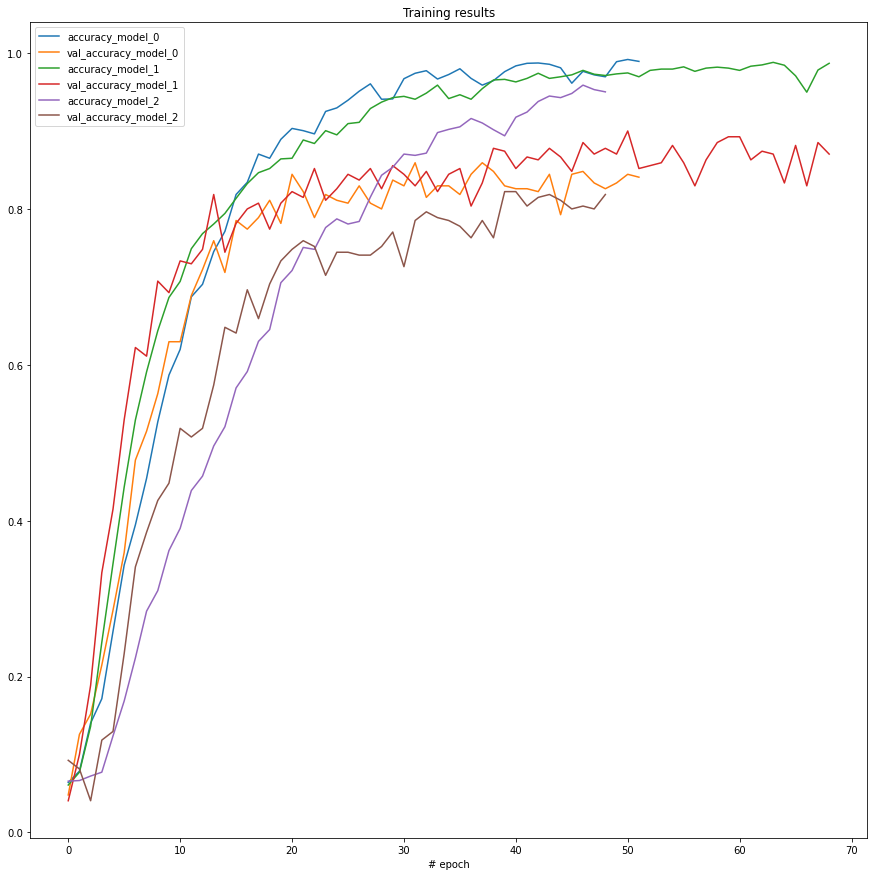


model_0
### Result of the predictions using 300 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.62      0.81      0.70        16
           2       0.95      0.86      0.90        22
           3       0.92      1.00      0.96        22
           4       1.00      0.91      0.95        22
           5       0.89      0.76      0.82        21
           6       0.95      1.00      0.98        20
           7       0.83      0.90      0.86        21
           8       0.85      0.81      0.83        21
           9       1.00      0.91      0.95        23
          10       1.00      0.88      0.94        17
          11       0.90      1.00      0.95        18
          12       0.73      0.85      0.79        13
          13       0.83      0.75      0.79        20
          14       0.91      0.88      0.89        24

    accuracy                           0.87   

In [18]:
# Divide train and test data
frac_train = 0.9
# Validation split 
validation_split = 0.1
# epochs
epochs = 100
# batch size
batch_size = 128
# loss
loss = ['categorical_crossentropy']
# optimizer
optimizer = ['adam', 'rmsprop']
# seed
seed = 1
# verbose
verbose = 1
# compile the models
model_0.compile(loss=loss[0], optimizer=optimizer[0], metrics=['accuracy'])
model_1.compile(loss=loss[0], optimizer=optimizer[0], metrics=['accuracy'])
model_2.compile(loss=loss[0], optimizer=optimizer[0], metrics=['accuracy'])


df = df.sample(frac=1,random_state=seed)

idx_train = int(np.floor(frac_train*df.shape[0]))



print("### some parameters ###")
print("test size  "+str(df.shape[0]-idx_train))
print("train size "+str(int(np.ceil(idx_train*(1-validation_split)))))
print("val size   "+str(int(np.ceil(idx_train*validation_split))))
print("batch size "+str(batch_size))


print("\n### decoding data ###")
inputs_train= {'gray_input':  np.stack(df["GrayImage"].iloc[0:idx_train].apply( lambda x: _str_to_arr_g(x,sze),0 )),
         'sobel_input': np.stack(df["SobelEdgeXY"].iloc[0:idx_train].apply( lambda x: _str_to_arr_g(x,sze),0 )), 
         'color_input': np.stack(df.iloc[0:idx_train].apply(lambda x: _str_to_arr_c(x["Blue"], x["Green"], x["Red"], sze), axis=1 ),0)}
outputs_train = {'output': to_categorical( np.asarray(df["Label"].iloc[0:idx_train]),n_fruit)}

inputs_test= {'gray_input':  np.stack(df["GrayImage"].iloc[idx_train:].apply( lambda x: _str_to_arr_g(x,sze),0 )),
         'sobel_input': np.stack(df["SobelEdgeXY"].iloc[idx_train:].apply( lambda x: _str_to_arr_g(x,sze),0 )), 
         'color_input': np.stack(df.iloc[idx_train:].apply(lambda x: _str_to_arr_c(x["Blue"], x["Green"], x["Red"], sze), axis=1 ),0)}
outputs_test = {'output': to_categorical( np.asarray(df["Label"].iloc[idx_train:]),n_fruit)}

df = None

# Run the garbage collector
gc.collect()

model_0, model_1, model_2 = compare_models(model_0, model_1, model_2, inputs_train, outputs_train, inputs_test, outputs_test, 
                   epochs, batch_size, validation_split, verbose)

In [19]:
print(mapper_fruit_names)

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


## Observations and Conclusions 

We wee that each model can learn to classify the data and give good accuracy results considering we are only using the 10% of the data set.

Regarding the run time we observe the following points:

1) The first model requires less time per epoch compared to the other models, since it has only one image of input and is a sequential model this was expected.

2) In each epoch, the second model takes similar time to the third model.

3) The models stopped at different epochs, this was due the presence of the **EarlyStopping** function, whose parameters can be changed to have same epoch stopping.


Regarding the *accuracy* plot we observe the following points:

1) The first and second model behaves in similar way, the apparent difference between them can be due to statistical noise. Although the second model seems to be have less oscillations in its *accuracy* plot.

2) The third model grows more slowly than the first or second, but it seems that given the appropriate stopping parameters can achieve the same accuracy plateau than the others.


Regarding the numerical results we see that:

1) The first model got the best accuracy, although the difference with the second model can be just statistical noise.

2) On average the first model is more precise than the others. Although, once again, its difference with the second model can be just noise.

3) Third model has less precision than the others.

4) In general Apple seems hard to classify. While Guava and Orange seems to be the more easy to classify. 


Considering all our observations we recommend use the first model, it gives good results, is easy to code, trains rapidly, it requires less preprocessing, making it our go to option. We also learned that the use of extra features, for modeling an ANN, must be done wisely.    

Future experiments can involve changing the following parameters:

1) For **loss** use loss=SparseCategoricalFocalLoss(gamma=2)  see https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.SparseCategoricalFocalLoss.html#focal_loss.SparseCategoricalFocalLoss

2) For **optimizer** use optimizer='rmsprop' 

3) For **activation** use  activation='tanh'

4) For **partial_out** use 100

5) For **n_times** use 4

Finally, it would be interesting compare results with pretrained models, as resnet18. 